<a href="https://colab.research.google.com/github/froggagul/nsmc/blob/master/Naver_sentiment_movie_after.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# download raw datasets
import requests


f_train = requests.get('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
f_test = requests.get('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

open('train.txt', 'wb').write(f_train.content)
open('test.txt', 'wb').write(f_test.content)

4893335

In [3]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 8.0 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
     |████████████████████████████████| 636 kB 59.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertModel, AdamW
from tqdm.notebook import tqdm

# reproducible pytorch
torch.manual_seed(1234)

In [5]:
class NSMCDataset(Dataset):
    def __init__(self, file_path):
        self.dataset = pd.read_csv(file_path, sep='\t')
        
        # drop duplicate row
        self.dataset['document'] = self.dataset['document'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
        self.dataset['document'] = self.dataset['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 a-zA-Z0-9]","")
        self.dataset.drop_duplicates(subset=['document'], inplace=True)
        # drop nan row
        self.dataset = self.dataset.dropna(axis = 0)
        
        # tokenizer
        self.tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
  
        # add special tokens
        self.tokenizer.add_tokens(["OO", "OOO", "OOOO"], special_tokens=True)
        
    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx, 1:3].values # no ids!
    
        '''
        ["document", "label"]
        '''
        document = row[0]
        label = row[1]

        inputs = self.tokenizer(
            document, 
            return_tensors='pt',
            truncation=True,
            max_length=256,
            pad_to_max_length=True,
            add_special_tokens=True
            )

        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        return input_ids, attention_mask, label

In [6]:
train_dataset = NSMCDataset("train.txt")
test_dataset = NSMCDataset("test.txt")

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [7]:
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = BertModel.from_pretrained("kykim/bert-kor-base")
        self.fc = nn.Linear(768, 2)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids = input_ids, attention_mask = attention_mask)

        pooled_output = outputs[1]
        return self.fc(pooled_output)

In [8]:
device = torch.device("cuda")
model = BertClassifier()

model.to(device)

model.bert_model.resize_token_embeddings(len(train_dataset.tokenizer))

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(42003, 768)

In [9]:
epochs = 4
batch_size = 16

In [10]:
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [12]:
losses = []
train_accuracies = []
test_accuracies = []

def test(epoch):
    model.eval()

    test_correct = 0
    test_total = 0

    for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
        y_batch = y_batch.to(device)
        y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))
        predicted = torch.max(y_pred, 1)[1]
        test_correct += (predicted == y_batch).sum()
        test_total += len(y_batch)

    print(f"epoch #{epoch} Accuracy: {test_correct.float() / test_total}")
    test_accuracies.append(test_correct.float() / test_total)

def train():
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        correct = 0
        total = 0
        batch_index = 0

        model.train()

        for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()

            y_batch = y_batch.to(device)
            input_ids_batch = input_ids_batch.to(device)
            attention_masks_batch = attention_masks_batch.to(device)
            
            y_pred = model(input_ids=input_ids_batch, attention_mask=attention_masks_batch)
            loss = F.cross_entropy(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()

            predicted = torch.max(y_pred, 1)[1]
            correct += (predicted == y_batch).sum()
            total += len(y_batch)

            batch_index += 1
            if batch_index % 500 == 0:
                print(f"epoch #{epoch} {batch_index} Batch Loss:{total_loss} Train Accuracy:{correct.float() / total}")

        losses.append(total_loss)
        train_accuracies.append(correct.float() / total)
        print(f"Train Loss: {total_loss} Train Accuracy:{correct.float() / total}")

        torch.save(model.state_dict(), f"model_{epoch}_v2.pt")

        test(epoch)

train()

  0%|          | 0/9026 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


epoch #1 500 Batch Loss:174.96340940147638 Train Accuracy:0.8488750457763672
epoch #1 1000 Batch Loss:332.1135129928589 Train Accuracy:0.8582500219345093
epoch #1 1500 Batch Loss:478.0041113011539 Train Accuracy:0.8640416860580444
epoch #1 2000 Batch Loss:622.8247666042298 Train Accuracy:0.8679687976837158
epoch #1 2500 Batch Loss:764.8328526820987 Train Accuracy:0.870574951171875
epoch #1 3000 Batch Loss:902.2340060640126 Train Accuracy:0.8731458187103271
epoch #1 3500 Batch Loss:1036.8095176517963 Train Accuracy:0.8749107122421265
epoch #1 4000 Batch Loss:1170.1441414970905 Train Accuracy:0.8760938048362732
epoch #1 4500 Batch Loss:1305.3873774632812 Train Accuracy:0.8777360916137695
epoch #1 5000 Batch Loss:1434.2903173100203 Train Accuracy:0.8791999816894531
epoch #1 5500 Batch Loss:1561.6240679100156 Train Accuracy:0.8804886341094971
epoch #1 6000 Batch Loss:1687.8426523506641 Train Accuracy:0.8818645477294922
epoch #1 6500 Batch Loss:1808.6492594219744 Train Accuracy:0.8831346035

  0%|          | 0/12174 [00:00<?, ?it/s]

epoch #1 Accuracy: 0.902679979801178


  0%|          | 0/9026 [00:00<?, ?it/s]

epoch #2 500 Batch Loss:100.39853582531214 Train Accuracy:0.9196250438690186
epoch #2 1000 Batch Loss:196.31679733656347 Train Accuracy:0.9200000166893005
epoch #2 1500 Batch Loss:292.7793466160074 Train Accuracy:0.921875
epoch #2 2000 Batch Loss:390.15360877569765 Train Accuracy:0.9219688177108765
epoch #2 2500 Batch Loss:488.0934523791075 Train Accuracy:0.9217749834060669
epoch #2 3000 Batch Loss:589.129297950305 Train Accuracy:0.9211457967758179
epoch #2 3500 Batch Loss:685.8373686224222 Train Accuracy:0.9214642643928528
epoch #2 4000 Batch Loss:787.3654053229839 Train Accuracy:0.9210312962532043
epoch #2 4500 Batch Loss:886.4732824219391 Train Accuracy:0.9210000038146973
epoch #2 5000 Batch Loss:983.231489347294 Train Accuracy:0.9209749698638916
epoch #2 5500 Batch Loss:1083.7894837204367 Train Accuracy:0.920840859413147
epoch #2 6000 Batch Loss:1180.7996842665598 Train Accuracy:0.9208958148956299
epoch #2 6500 Batch Loss:1280.7158396113664 Train Accuracy:0.920846164226532
epoch #2

  0%|          | 0/12174 [00:00<?, ?it/s]

epoch #2 Accuracy: 0.9072595238685608


  0%|          | 0/9026 [00:00<?, ?it/s]

epoch #3 500 Batch Loss:74.83786737918854 Train Accuracy:0.9451250433921814
epoch #3 1000 Batch Loss:147.1864611445926 Train Accuracy:0.945062518119812
epoch #3 1500 Batch Loss:213.7846307400614 Train Accuracy:0.9462082982063293
epoch #3 2000 Batch Loss:283.99697463586926 Train Accuracy:0.9462813138961792
epoch #3 2500 Batch Loss:359.23936645081267 Train Accuracy:0.945099949836731
epoch #3 3000 Batch Loss:427.30940120108426 Train Accuracy:0.945645809173584
epoch #3 3500 Batch Loss:497.27094369754195 Train Accuracy:0.9458214044570923
epoch #3 4000 Batch Loss:568.4668893604539 Train Accuracy:0.9457656741142273
epoch #3 4500 Batch Loss:634.6936673175078 Train Accuracy:0.9463611245155334
epoch #3 5000 Batch Loss:708.8368854704313 Train Accuracy:0.9458999633789062
epoch #3 5500 Batch Loss:778.1521524824202 Train Accuracy:0.9462727308273315
epoch #3 6000 Batch Loss:852.908579592593 Train Accuracy:0.94572913646698
epoch #3 6500 Batch Loss:930.3353333235718 Train Accuracy:0.9454134702682495
ep

  0%|          | 0/12174 [00:00<?, ?it/s]

epoch #3 Accuracy: 0.9088202714920044


  0%|          | 0/9026 [00:00<?, ?it/s]

epoch #4 500 Batch Loss:47.02835032180883 Train Accuracy:0.9653750658035278
epoch #4 1000 Batch Loss:96.74765822174959 Train Accuracy:0.963937520980835
epoch #4 1500 Batch Loss:144.62664991267957 Train Accuracy:0.9647083282470703
epoch #4 2000 Batch Loss:195.36956831160933 Train Accuracy:0.9644375443458557
epoch #4 2500 Batch Loss:248.93737904634327 Train Accuracy:0.9634249806404114
epoch #4 3000 Batch Loss:300.2322368498426 Train Accuracy:0.9636250138282776
epoch #4 3500 Batch Loss:349.3531129208859 Train Accuracy:0.9638214111328125
epoch #4 4000 Batch Loss:403.7514136200771 Train Accuracy:0.963437557220459
epoch #4 4500 Batch Loss:454.73679077788256 Train Accuracy:0.9633889198303223
epoch #4 5000 Batch Loss:507.1746067556087 Train Accuracy:0.9630874991416931
epoch #4 5500 Batch Loss:561.7337417621166 Train Accuracy:0.9627727270126343
epoch #4 6000 Batch Loss:614.5528677375987 Train Accuracy:0.9625833034515381
epoch #4 6500 Batch Loss:666.8827484770445 Train Accuracy:0.962317287921905

  0%|          | 0/12174 [00:00<?, ?it/s]

epoch #4 Accuracy: 0.9065818190574646


In [ ]:
losses, test_accuracies, train_accuracies

([1226.6280853841454,
  896.1151333004236,
  682.3519245530479,
  502.30119440332055],
 [tensor(0.8873, device='cuda:0'),
  tensor(0.9220, device='cuda:0'),
  tensor(0.9430, device='cuda:0'),
  tensor(0.9589, device='cuda:0')])

In [13]:
losses, test_accuracies, train_accuracies

([2434.7418749146163,
  1768.5735948150977,
  1300.3707584196236,
  932.287875744747],
 [tensor(0.9027, device='cuda:0'),
  tensor(0.9073, device='cuda:0'),
  tensor(0.9088, device='cuda:0'),
  tensor(0.9066, device='cuda:0')],
 [tensor(0.8874, device='cuda:0'),
  tensor(0.9213, device='cuda:0'),
  tensor(0.9446, device='cuda:0'),
  tensor(0.9617, device='cuda:0')])

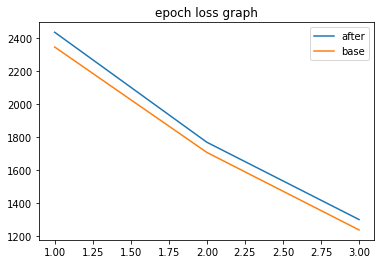

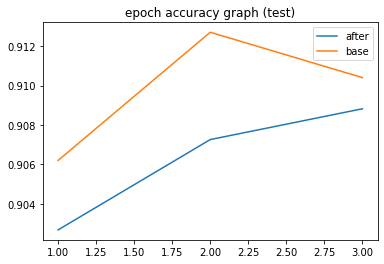

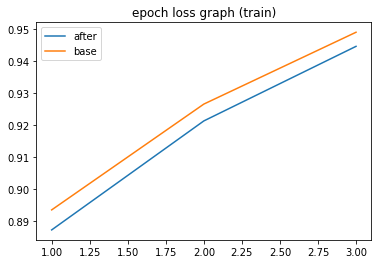

In [21]:
from matplotlib import pyplot as plt

epochs = [1, 2, 3]
plt.title('epoch loss graph')
plt.plot(epochs, losses[:3], label="after")
plt.plot(epochs, [2345.2733005695045, 1706.86134163104, 1237.497708305018], label="base")
plt.legend()
plt.show()
plt.title('epoch accuracy graph (test)')
plt.plot(epochs, test_accuracies[:3], label="after")
plt.plot(epochs, [0.9062, 0.9127, 0.9104], label="base")
plt.legend()
plt.show()
plt.title('epoch loss graph (train)')
plt.plot(epochs, train_accuracies[:3], label="after")
plt.plot(epochs, [0.8936, 0.9266, 0.9490], label="base")
plt.legend()
plt.show()
